# Data preparation and manipulation

In [1]:
import PIPS
import matplotlib.pyplot as plt
import time
import numpy as np

The ```photdata``` object in PIPS provides tools to perform basic operation for data manipulation. The implemented operation in the current version includes the following:

- Initialization
- Basic info / note storage
- Basic information check (```print()```, ```len()```, etc.)
- Data identity check (are two ```photdata``` objects identical?)
- Data cut (remove data points with uncertainty above threshold)
- Data cut reset
- Data concatenation

## Initialization

The main function of ```photdata``` is to hold the photometric data. The object requires a list or array or three elements, ```x```, ```y```, and ```yerr``` each containing the same length of the time, magnitude (or flux), and magnitude-uncertainty data.

For convenience, datafile generated by [LOSSPhotPipeline]('https://github.com/benstahl92/LOSSPhotPipeline') can be directly imported using a helper function ```data_readin_LPP```.

In [2]:
data = PIPS.data_readin_LPP('../sample_data/005.dat',filter='V')
x,y,yerr = data
print('data shape:\t',np.array(data).shape)
print('x shape:\t',x.shape)
print('y shape:\t',y.shape)
print('y-error shape:\t',yerr.shape)

data shape:	 (3, 103)
x shape:	 (103,)
y shape:	 (103,)
y-error shape:	 (103,)


The most basic method to initialize data is to give ```data=[x,y,yerr]``` as an argument for ```PIPS.photdata()```.
The initialization function also accepts ```label``` and ```band``` arguments, each of which should be used to store information.

In [3]:
star  = PIPS.photdata(data) # the most basic way to initialize object
star2 = PIPS.photdata(data,label='Star2',band='V') # same as star1, but with more info

## Printing information
```photdata``` accepts some basic python operations, such as ```str()```, ```print()```, ```len()```, and ```hash()```. These can be used to check certain properties of the object.

In [9]:
# basic information check
print('* Basic information check')
print(star)              # the basic information
print(star2)             # the basic information -- label and filter info is included
print(len(star))         # number of datapoints
print(hash(star))

* Basic information check


TypeError: object of type 'photdata' has no len()

## Checking if two objects are identical

In [4]:
print('when two objects have the same data, they are considered identical')
print(star == star2)     # two objects are identical (hash-equality)

print('\nIf any of the data points are changed, they are not identical anymore')
star3 = star2.copy()    # creates a copy of star3 (including all attributes)
star3.x[-1] = 0         # manually change the data (don't do this!)
print('star == star3:', star == star3)    # now that the data itself is changed, they are not identical

when two objects have the same data, they are considered identical
False

If any of the data points are changed, they are not identical anymore


AttributeError: 'photdata' object has no attribute 'copy'

## Applying cuts

The ```cut()``` function in ```photdata``` object offers a quick and easy way to apply data cuts. It takes in ```xmin, xmax, ymin, ymax, yerr_min, yerr_max``` arguments, and any combination of these can be applied simultaneously. Once cuts are applied, the existing cuts are effective even when a user applies another cut on different parameter later.

In [6]:
period,_=star.get_period(multiprocessing=False)

Before cuts: <PIPS.class_photdata.photdata object at 0x000001AC5F7E3608>


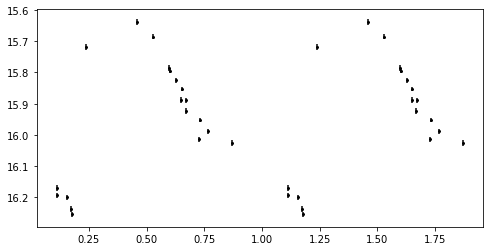

After a cut: <PIPS.class_photdata.photdata object at 0x000001AC5F7E3608>


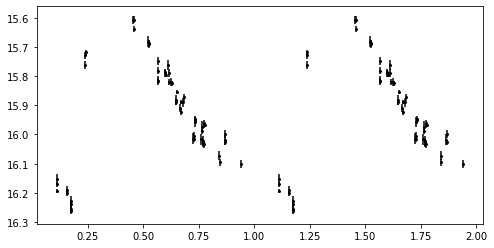

After cut reset: <PIPS.class_photdata.photdata object at 0x000001AC5F7E3608>


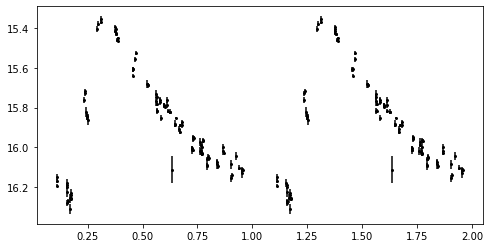

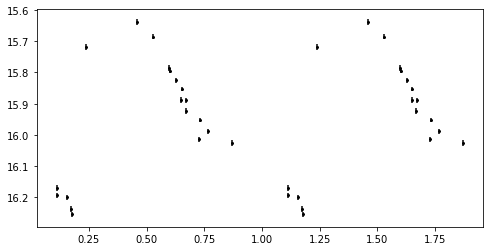

After another cut: <PIPS.class_photdata.photdata object at 0x000001AC5F7E3608>
* Even after cuts are applided, two originally identical objects are still identical
star == star2: False


In [13]:
# manipulate data
print('Before cuts:', star2)        # info before cuts are applied
star2.plot_lc(period); plt.show()
star2.cut(yerr_max=0.02)            # cuts data (based on x, y, and yerr values)
print('After a cut:', star2)        # now data is shorter
star2.plot_lc(period); plt.show()
star2.reset_cuts()
print('After cut reset:', star2)    # reset the cut settings
star2.plot_lc(period); plt.show()

star2.cut(ymin = 15.8)                 # a cut
star2.cut(yerr_max = 0.01, xmin=58676) # additional cuts
print('After another cut:', star2)  # now both yerr_min and ymin are applied
star2.plot_lc(period); plt.show()
print('* Even after cuts are applided, two originally identical objects are still identical')
print('star == star2:', star == star2)      # raw data is internally preserved 




## Combining / concatenating two objects
It is sometimes necessary to merge two sets of data reduced/prepared separately. PIPS offers a quick way to merge two datasets using ```+``` (add) operator.

In [ ]:
# more!
print(star)
print(star2)
star4 = star + star2     # data concatenation (returns another photdata object)
star4.label = 'Star4'    # always add labels
print(star4)             # star4 has more datapoints (notice cuts are applied to star2)
print('star == star4:', star == star4)     # once the data itself is changed, they are not identical